In [1]:
from google.colab import drive
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Function to load and preprocess images
def load_images_from_folder(folder_path, label, resize=(224, 224)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert("RGB")
            img_resized = img.resize(resize)  # Resize to 224x224
            images.append(np.array(img_resized) / 255.0)  # Normalize
            labels.append(label)
    return images, labels

# Paths to original HOLES and NO HOLES datasets
holes_folder = '/content/drive/MyDrive/DAISY2.0 Data/DEC_data_cropped/HOLES'  # Replace with your path
no_holes_folder = '/content/drive/MyDrive/DAISY2.0 Data/DEC_data_cropped/NO HOLES'  # Replace with your path

# Load HOLES (defect images) and NO HOLES (non-defect images)
holes_images, holes_labels = load_images_from_folder(holes_folder, label=1)
no_holes_images, no_holes_labels = load_images_from_folder(no_holes_folder, label=0)

In [8]:
import os

# Function to count files in a folder
def count_patches_in_folder(folder_path):
    patch_count = len([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg', '.tif'))])
    return patch_count

# Paths to the patch folders
defect_patches_folder = '/content/drive/MyDrive/DAISY2.0 Data/DEC_data_cropped/defect patches'  # Replace with your path
holes_with_patches_folder = '/content/drive/MyDrive/DAISY2.0 Data/DEC_data_cropped/PATCHES'  # Replace with your path
no_holes_with_patches_folder = '/content/drive/MyDrive/DAISY2.0 Data/DEC_data_cropped/PATCHES_nh'  # Replace with your path

# Count patches in each folder
defect_patch_count = count_patches_in_folder(defect_patches_folder)
holes_patch_count = count_patches_in_folder(holes_with_patches_folder)
no_holes_patch_count = count_patches_in_folder(no_holes_with_patches_folder)

# Print results
print(f"Number of patches in DEFECT_PATCHES: {defect_patch_count}")
print(f"Number of patches in HOLES_WITH_PATCHES: {holes_patch_count}")
print(f"Number of patches in NO_HOLES_WITH_PATCHES: {no_holes_patch_count}")


Number of patches in DEFECT_PATCHES: 1022
Number of patches in HOLES_WITH_PATCHES: 248
Number of patches in NO_HOLES_WITH_PATCHES: 986


In [12]:
# Load patch dataset
def load_patches_from_folder(folder_path, label):
    patches = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tif')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert("RGB")
            patches.append(np.array(img) / 255.0)  # Normalize pixel values
            labels.append(label)
    return patches, labels

# Paths to patch folders
defect_patches_folder = '/content/drive/MyDrive/DAISY2.0 Data/DEC_data_cropped/defect patches'  # Replace with your path
non_defect_patches_folder_1 = '/content/drive/MyDrive/DAISY2.0 Data/DEC_data_cropped/PATCHES'  # Replace with your path
non_defect_patches_folder_2 = '/content/drive/MyDrive/DAISY2.0 Data/DEC_data_cropped/PATCHES_nh'  # Replace with your path

# Load patches
defect_patches, defect_labels = load_patches_from_folder(defect_patches_folder, label=1)
non_defect_patches_1, non_defect_labels_1 = load_patches_from_folder(non_defect_patches_folder_1, label=0)
non_defect_patches_2, non_defect_labels_2 = load_patches_from_folder(non_defect_patches_folder_2, label=0)

# Combine all data (original + patches)
all_images = holes_images + no_holes_images + defect_patches + non_defect_patches_1 + non_defect_patches_2
all_labels = holes_labels + no_holes_labels + defect_labels + non_defect_labels_1 + non_defect_labels_2

# Convert to numpy arrays
X = np.array(all_images)
y = np.array(all_labels)

print(f"Total dataset size: {X.shape}, Labels: {y.shape}")


Total dataset size: (2402, 224, 224, 3), Labels: (2402,)


In [10]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [13]:
# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (1921, 224, 224, 3), (1921,)
Validation set: (240, 224, 224, 3), (240,)
Test set: (241, 224, 224, 3), (241,)


In [14]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout regularization
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train only the custom layers
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,  # Start with a few epochs
    batch_size=32,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 209ms/step - accuracy: 0.5226 - loss: 0.8154 - val_accuracy: 0.5792 - val_loss: 0.6490
Epoch 2/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6142 - loss: 0.6616 - val_accuracy: 0.6458 - val_loss: 0.6275
Epoch 3/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6269 - loss: 0.6425 - val_accuracy: 0.6333 - val_loss: 0.6403
Epoch 4/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5799 - loss: 0.6691 - val_accuracy: 0.6792 - val_loss: 0.6164
Epoch 5/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6390 - loss: 0.6381 - val_accuracy: 0.7333 - val_loss: 0.5984
Epoch 6/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6568 - loss: 0.6297 - val_accuracy: 0.7500 - val_loss: 0.5948
Epoch 7/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6273 - loss: 0.6465 - val_accuracy: 0.6500 - val_loss: 0.6126
Epoch 8/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accur

In [15]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Test Loss: 0.5841987729072571
Test Accuracy: 0.7344398498535156


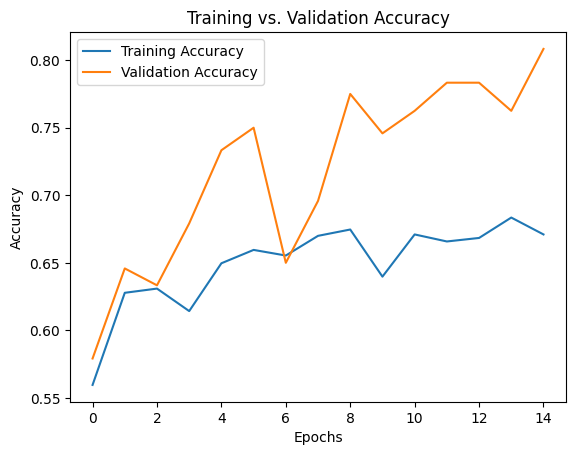

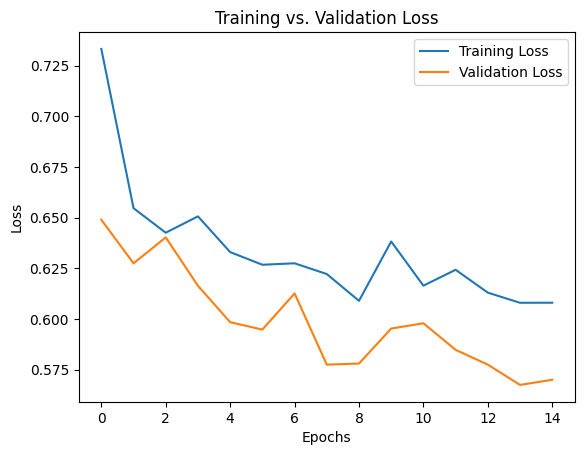

In [16]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 531ms/step


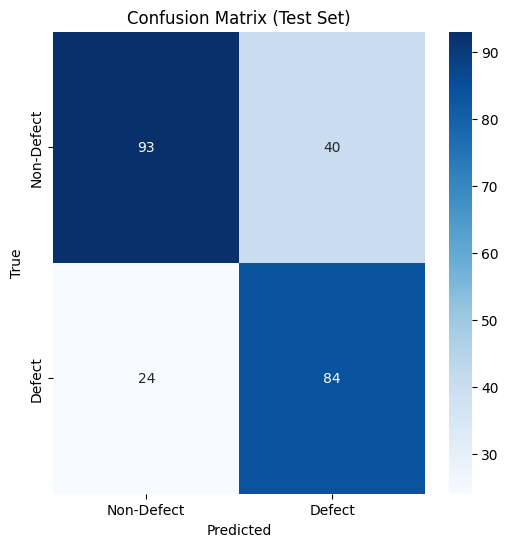

Classification Report (Test Set):
              precision    recall  f1-score   support

  Non-Defect       0.79      0.70      0.74       133
      Defect       0.68      0.78      0.72       108

    accuracy                           0.73       241
   macro avg       0.74      0.74      0.73       241
weighted avg       0.74      0.73      0.74       241



In [17]:
# Predict on test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Defect', 'Defect'], yticklabels=['Non-Defect', 'Defect'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred, target_names=['Non-Defect', 'Defect']))


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


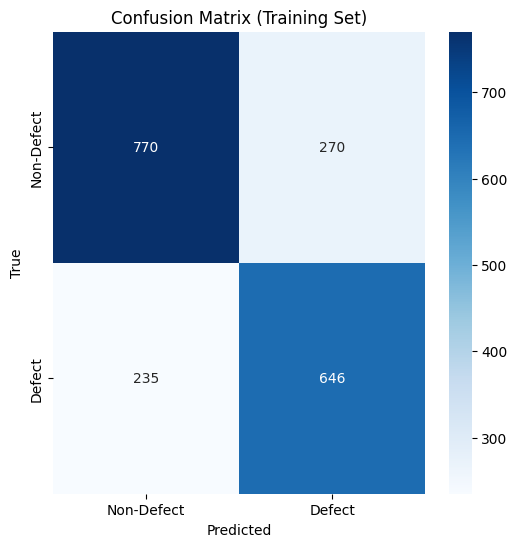

Classification Report (Training Set):
              precision    recall  f1-score   support

  Non-Defect       0.77      0.74      0.75      1040
      Defect       0.71      0.73      0.72       881

    accuracy                           0.74      1921
   macro avg       0.74      0.74      0.74      1921
weighted avg       0.74      0.74      0.74      1921



In [18]:
# Predict on the training set
y_train_pred = (model.predict(X_train) > 0.5).astype("int32")

# Compute confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Defect', 'Defect'], yticklabels=['Non-Defect', 'Defect'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Training Set)')
plt.show()

# Print classification report
print("Classification Report (Training Set):")
print(classification_report(y_train, y_train_pred, target_names=['Non-Defect', 'Defect']))


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step


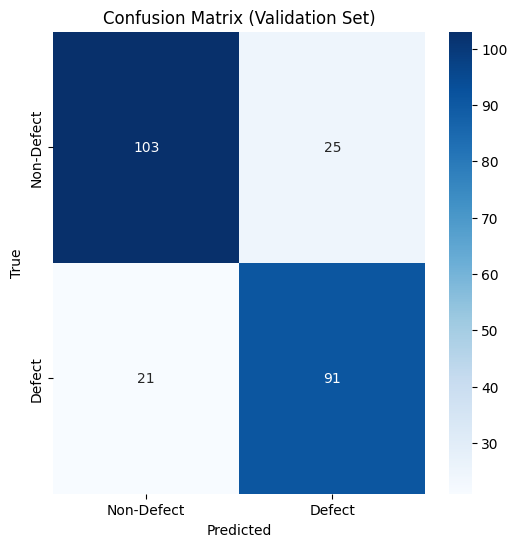

Classification Report (Validation Set):
              precision    recall  f1-score   support

  Non-Defect       0.83      0.80      0.82       128
      Defect       0.78      0.81      0.80       112

    accuracy                           0.81       240
   macro avg       0.81      0.81      0.81       240
weighted avg       0.81      0.81      0.81       240



In [19]:
# Predict on the validation set
y_val_pred = (model.predict(X_val) > 0.5).astype("int32")

# Compute confusion matrix
cm_val = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Defect', 'Defect'], yticklabels=['Non-Defect', 'Defect'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

# Print classification report
print("Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=['Non-Defect', 'Defect']))